In [1]:
#This is for Know the satellites position with a specific time and date 

In [2]:
#Now I need to know the near 
import os, sys, time, datetime, re, gpstk
from ftplib import FTP
import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import math

secsInWeek = 604800 
secsInDay = 86400 
gpsEpoch = (1980, 1, 6, 0, 0, 0)  # (year, month, day, hh, mm, ss)

%matplotlib inline
#%run -i code/utils.py

In [3]:
def UTC2GPS(fecha):
    '''
    @UTC2GPS: Método estático para convertir un objeto de la clase datetime a tiempo GPS
    @fecha datetime: Objeto de la clase datetime con la fecha a transformar en tiempo GPS.
    '''
    ## Obtenemos el número del día
    ## En python el día 0 es el lunes
    day = fecha.weekday()
    ## Si el día es Domingo (número 6) -> día = -1
    if day == 6 : day = -1
    ## Calculamos el tiempo GPS
    return ( (day + 1) * 86400 ) + int(fecha.strftime('%H')) * 3600 + int(fecha.strftime('%M')) * 60 + int(fecha.strftime('%S'))

In [4]:
def to_radians(array):
    rads = array*(np.pi /180.)
    return rads

def compute_distance(df,longitude, latitude):
    R = 6371e3 # earth radius metres, mean radius = 6371km
    n = len(df.Latitude)
    ArrayLat = pd.Series([latitude] * n)
    ArrayLon = pd.Series([longitude] * n)
    #print len(ArrayLat), type(ArrayLat), type(df.Latitude)
    phi1 = to_radians(df.Latitude) #degrees to radians
    phi2 = to_radians(ArrayLat)
    lambda1 = to_radians(df.Longitude)
    lambda2 = to_radians(ArrayLon)
    dphi = phi2 - phi1
    dlambda = lambda2 - lambda1
    a = np.sin(dphi/2.)**2 + (np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2.)**2 )
    c = 2 * np.arctan2(np.sqrt(a),np.sqrt(1.-a))
    d = R * c
    return d

float_formatter = lambda x: "%.2f" % x

def to_skyplot(elevation, azimut):
    e = np.array(elevation)
    a = np.array(azimut)
    sx = ((90-e)/90) * np.sin (a * (np.pi/180))
    sy = ((90-e)/90) * np.cos (a * (np.pi/180))
    return (sx,sy)

In [5]:
#Thanks to https://github.com/twillis449
def gunzip_some_file(compressed_file,
                     uncompressed_file,
                     delete_file = 1):
    print 'uncompressing file 1 to file 2 ', compressed_file, uncompressed_file
# if file is already uncompressed, do nothing
    if compressed_file == uncompressed_file:
        return
    # make sure there is a file
    if not os.path.isfile(compressed_file):
        if(compressed_file[-1] == 'Z'):
            # try another form
            warnings.warn("No .Z form of compressed file '%s', trying .gz"%compressed_file)
            print "No .Z form of compressed file  trying .gz"
            new_compressed = compressed_file[:-1] + "gz"
            return gunzip_some_file(new_compressed, uncompressed_file,
                                    delete_file)
        raise Albus_RINEX.RINEX_Data_Barf("No such file '%s' to uncompress"%compressed_file)
    if compressed_file[-3:] != 'zip' and compressed_file[-1] != 'Z':
        # file is most likely uncompressed ...
        command = "mv  %s %s"%(compressed_file, uncompressed_file)
    elif (compressed_file[-3:] == 'zip'): # we have a trignet file
        command = "unzip -np %s '*d' > %s"%(compressed_file,uncompressed_file)
    else:   
        command = "gunzip -dc %s > %s"%(compressed_file,uncompressed_file)
    print 'gunzip executing ', command
    retcode = os.system(command)
    print 'gunzip returned ', retcode
# handle non-zero return code error from extraction 
    if(retcode):
        raise No_RINEX_File_Error("Could not run '%s'"%command)
    if(delete_file):
        try:
            os.remove(compressed_file)
        except:
            print 'failure to remove compressed file - probably not a compressed file'
    return


In [6]:
Sat_Time = "21:20:23"
Sat_Date = "23/02/2017"
Longitude_inGround = -73.1224429 
Latitude_inGround = 7.1388027


In [7]:
#Parse String to Date
import datetime

time_sat = datetime.datetime.strptime(Sat_Time,'%H:%M:%S')
date_sat = datetime.datetime.strptime(Sat_Date,'%d/%m/%Y')

InputDate = datetime.datetime.combine(datetime.date(date_sat.year, date_sat.month, date_sat.day), datetime.time(time_sat.hour, time_sat.minute,time_sat.second))
print InputDate

2017-02-23 21:20:23


In [8]:
day_of_year = InputDate.timetuple().tm_yday
day_of_year

54

In [9]:
UNAVCO_list = pd.read_csv("UNAVCOlist.csv")
UNAVCO_list.columns

IOError: File UNAVCOlist.csv does not exist

search the nearest station

In [9]:
#Universidad Industrial de Santander
Latitude_inGround,Longitude_inGround

(7.1388027, -73.1224429)

In [10]:
d = compute_distance(UNAVCO_list,Longitude_inGround,Latitude_inGround)
UNAVCO_list['Distance'] = d

In [11]:
UNAVCO_list.sort_values(['Distance'], ascending=[True], inplace=True)
UNAVCO_list

,Unnamed: 0,CODE,Longitude,Latitude,Distance
2632,2632,BUCM,-73.181700,7.116900,6977.043272
2673,2673,BUCM,-73.181700,7.116900,6977.043272
2901,2901,BUCM,-73.181700,7.116900,6977.043272
2690,2690,FLOR,-73.088600,7.041600,11435.389590
2668,2668,ARAT,-73.052200,6.703200,49053.488836
3048,3048,PLON,-72.649000,7.384000,58911.122695
25086,25086,MECE,-73.712000,7.107200,65144.656963
2728,2728,SOCO,-73.241700,6.462500,76345.500651
2871,2871,ABRE,-73.225900,8.086800,106027.388816
24149,24149,CUC1,-72.512800,7.932300,110911.258013


In [12]:
#search the nearest land stage
IDmin = UNAVCO_list.Distance.argmin()
S_Code = UNAVCO_list.CODE[IDmin]
S_Dist = UNAVCO_list.Distance[IDmin]
print S_Code,UNAVCO_list.Longitude[IDmin],UNAVCO_list.Latitude[IDmin],S_Dist

BUCM -73.1817 7.1169 6977.04327191


Now I have the Name of the Lan Station that I need.


In [13]:
UNAVCO_FTP = 'data-out.unavco.org'
NASA_FTP = 'cddis.gsfc.nasa.gov'

try:
    f = FTP(NASA_FTP)
    #f = FTP(UNAVCO_FTP)
    print f
    
except:
    pass
#print "Welcome:", f.getwelcome()
f.login()

#Now I wnat to look the folder that I need.
UNAVCO_FTP_path = '/pub/rinex/nav/' + str(InputDate.year) + '/' + str(day_of_year).zfill(3)
FTP_path ='/pub/gps/data/daily/'+ str(InputDate.year) + '/' + str(day_of_year).zfill(3) + '/' + str(InputDate.year)[2:] + 'n'

#[data-out.unavco.org] --> /pub/rinex/nav/2017/002
#[cddis.gsfc.nasa.gov] --> /pub/gps/data/daily/2017/001/17n --> 
#    FTP_path ='/pub/gps/data/daily/'+ str_year + '/' + str(day_of_year).zfill(3) + '/' + str_year[2:] + 'n'

print "Folder Needed:", f.cwd(FTP_path)
print "Current working directory:", f.pwd()

<ftplib.FTP instance at 0xacc8992c>
Folder Needed: 250 Directory successfully changed.
Current working directory: /pub/gps/data/daily/2017/054/17n


In [14]:
import os, sys
from ftplib import FTP 


LineData = 0
while (1):
    try:
        if(LineData>70):
            break
        IDmin = UNAVCO_list.Distance.argmin()
        NameStation = UNAVCO_list.CODE[IDmin]
        LineData += 1
        NameFile = NameStation.lower() + str(day_of_year).zfill(3) + '0.' + str(InputDate.year)[2:] + 'n.Z' 
        #For Now just GPS constallartion, I mean, .n file.'
        clear_output(wait=True)
        print("Try with station: %s" % (NameFile),"to " + str(float_formatter(UNAVCO_list.Distance[IDmin]/1000)) + " [Km]")
        print
        
        f.voidcmd("TYPE I")
        datasock, size = f.ntransfercmd("RETR "+ NameFile)
        bytes_so_far = 0
        fd = open(NameFile, 'wb')
        
        while 1:
            buf = datasock.recv(2048) 
            
            fd.write(buf)
            bytes_so_far += len(buf)
            clear_output(wait=True)
            print "Received",bytes_so_far, "of %d total bytes (%.1f%%)" % (size, 100 * bytes_so_far / float(size)),"bytes"
            sys.stdout.flush()
            if not buf:
                break
                 
            #if bytes_so_far == len(buf):
                #print 
                #break
        print("File %s" % (NameFile),"to " + str(float_formatter(UNAVCO_list.Distance[IDmin]/1000)) + " [Km]")
        fd.close()
        datasock.close()
        f.voidresp
        f.close()
        break
    except:
        UNAVCO_list = UNAVCO_list[UNAVCO_list.CODE != NameStation]

Received 40993 of 40993 total bytes (100.0%) bytes
('File medi0540.17n.Z', 'to 296.64 [Km]')


In [ ]:
NameFile

In [ ]:
gunzip_some_file(NameFile,'navRINEX',0)

In [ ]:
#!head -29 $navRINEX

In [10]:
UTC2GPS(datetime.datetime.now())

295510

In [23]:
def MeanToEccentricAnomaly(e,M):
    pi = math.pi
    if (e >= 1.0):
        print("MeanToEccenAnomaly does not support parabolic or hyperbolic orbits!")
    # Make sure M lies between -pi and pi
    M = math.fmod(M, 2*pi);
    if (M < pi):
        M = M + 2*pi
    elif (M > pi):
        M = M - 2*pi

    if ((M > -pi and M < 0) or (M > pi)):
        E = M - e
    else:
        E = M + e

    Enew = E
    zero = 1E-6;
    first = 1;
    while (first or abs(Enew - E) > zero):
        first = 0
        E = Enew
        Enew = E + (M - E + e*math.sin(E))/(1 - e*math.cos(E))

    E = Enew;
    return E

In [24]:
def TrueAnomaly(ec,E):
    '''
    ec = eccentricty  -  E = Eccentricity Anomaly
    '''
    return  math.atan( ( math.sqrt(1-ec**2)*math.sin(E) )/(math.cos(E) - ec  )  )

In [25]:
def GetPositionECEF(rj,fj):
    '''
    Position in Orbital Plane
    rj: Radial Distance - fj: True Anomaly
    http://web.ics.purdue.edu/~ecalais/teaching/geodesy/EAS_591T_2003_lab_4.htm
    '''
    x = rj * math.cos(fj)
    y = rj * math.sin(fj)
    return x,y
    

In [26]:
def GetPositionOrbitPlane(a,E,e):
    '''
        a: semi-major axis    E: Ecentric Anomaly   e: eccentricity
        http://ssd.jpl.nasa.gov/txt/aprx_pos_planets.pdf
    '''
    x = a*(math.cos(E) - e)
    y = a* math.sqrt(1-e**2)*math.sin(E)
    z = 0
    return x,y
    

In [27]:
def GetFirstPointAries(r,omg,w,v,i):
    '''
    r: Radial distance , Omega: Longitud for ascending node , w:  Agument pf perigee 
    v: True Anomaly    , i:  Inclination
    http://www.davidcolarusso.com/astro/#helioeclipxyz
    '''
    x = r*(math.cos(omg) * math.cos(w+v) - math.sin(omg)*math.sin(w+v)*math.cos(i))
    y = r*(math.sin(omg) * math.cos(w+v) - math.cos(omg)*math.sin(w+v)*math.cos(i))
    z = r*math.sin(w+v)*math.sin(i)
    return x,y,z
    

In [28]:
def GetHeliocentricCoordenates(x,y,z,i):
    '''
    From x,y,z area First Posint Aries coordenates
    i: Inclination     x,y,z: Orbital Plane Position
    '''
    y2 = (y*math.cos(i)-z*math.sin(i))
    z2 = (y*math.sin(i)+z*math.cos(i))
    return x,y2,z2

In [29]:
def GetRightAscensionDeclination(x,y,z):
    '''
    x,y,z: Position in Heliocentric Coordenates
    '''
    RA = math.atan(y/x)
    DE = math.atan(z/(math.sqrt(x**2+y**2)))
    return RA, DE

In [79]:
def GetRA_Dec(E,ec,a,w,omg,i):
    '''
    RA: Right Ascension    -  Dec: Declination
    E = Eccentricity Anomaly    - ec: eccentricity        -  a: semi major axis
    http://www.davidcolarusso.com/astro/#helioeclipxyz
    '''
    
    v = 2* math.tan( math.sqrt( (1+ec)/(1-ec) )* math.tan(E/2) )
    r = (a*1-ec**2)/(1+ec*math.cos(v))
    x = r*(math.cos(omg) * math.cos(w+v) - math.sin(omg)*math.sin(w+v)*math.cos(i))
    y = r*(math.sin(omg) * math.cos(w+v) - math.cos(omg)*math.sin(w+v)*math.cos(i))
    z = r*math.sin(w+v)*math.sin(i)
    ra,dec = GetRightAscensionDeclination(x,y,z)
    print ra,dec
    

In [48]:
def MatrixRotation(omg,w,i,r):
    A = math.cos(omg)*math.cos(w) - math.sin(omg)*math.sin(w)*math.cos(i)
    B = math.cos(omg)*math.sin(w) - math.sin(omg)*math.cos(w)*math.cos(i)
    C = math.sin(omg)*math.sin(i)
    
    D = math.sin(omg)*math.cos(w) - math.cos(omg)*math.sin(w)*math.cos(i)
    E = math.sin(omg)*math.sin(w) - math.cos(omg)*math.cos(w)*math.cos(i)
    F = (-1.)*math.cos(omg)*math.sin(i)
    
    G = math.sin(w)*math.sin(i)
    H = math.cos(w)*math.sin(i)
    I = math.cos(i)
    
    R = np.array([[A,B,C], [D,E,F], [G,H,I]])
    #print R
    T = R*r
    return T
    

Info about coordinate system [here](https://stereo-ssc.nascom.nasa.gov/coordinates_explanation.shtml)

In [81]:
def future_position(e,t_data,GPSweek):
    import math
    #%run -i utils/utils.py
    
    GM = 3.986004418e14     # [m^3 / s^2] value of earth universal gravitational parameter for GPS user. 
    w_e = 7.2921151467e-5   # [rad/s] Value of earth rotation
    toe = e.HOWtime   # Ephemeris time
    M_o = e.M0  # Mean Anomaly
    #print "Mean ANomaly from RINEX: ",M_o
    
    a = e.A # semi-major axis
    ec = e.ecc #Eccentricity
    delta_n = e.dn  # mean motion difference From Computed value
    #n_o = math.sqrt(GM/math.pow(a,3))   # computed mean motion
    t = t_data - toe  # Time from ephemeris refrence epoc
    
    if t < -302400:
        t += 604800
    if t > 302400:
        t -= 604800
        
    #print "my new time: ", t_data, " - ephemeris time: ", toe, " - diff time: ",t
    u_j = M_o + (math.sqrt(GM/(a**3)) + delta_n) * t          #Mean Anomaly at my time (rad/secs)
    #n = n_o + delta_n  #corrected mean motion
    #M_k = M_o + n     # Mean Anomaly
    #E = GetEccentricAnomaly(ec,u_j,4)   # E = eccentric anomaly
   
    E = MeanToEccentricAnomaly(ec,u_j)
    #print "Eccentric Anomaly : ",E
    M = E - ec*math.sin(E)
    fj = TrueAnomaly(ec,E)
    # with the E, I can get M,, the M in the new ephoc M = E - ec*sin(E)
    Omegaj = e.OMEGA0 + (e.OMEGAdot - w_e)*t - w_e*toe  #Longitude for ascending node
    #print "omega_j: ",Omegaj
    wj = e.w + fj + e.Cuc*math.cos(2*(e.w+fj)) + e.Cus*math.sin(2*(e.w+fj)) #Argument of Perigee
    #print "Argument of peroigee:",wj
    rj = a*(1 - ec*math.cos(E)) + e.Crc*math.cos(2*(e.w+fj)) + e.Crs*math.sin(2*(e.w+fj)) #Radial distance
    ij = e.i0 + e.idot*t + e.Cic*math.cos(2*(e.w+fj)) + e.Cis*math.sin(2*(e.w+fj)) # Inclination
    #print "Radial distance: ", rj, " - new Inclination:", ij
    
    #toECEF frame
    x,y = GetPositionECEF(rj,fj)
    r = np.array([[x,y,0]])
    POS = MatrixRotation(Omegaj,wj,ij,r)
    #print "Position apply rotation: ",POS
    x2,y2 = GetPositionOrbitPlane(a,E,ec)
    x3,y3,z3 = GetFirstPointAries(rj,Omegaj,wj,fj,ij)
    #print "Position ECEF: x: ",x," ::: y: ",y
    #print "GetPositionOrbitPlane Coordenate: x: ", x2," ::: y: ",y2
    #print "First Point Aries: ",x3," ::: ",y3," ::: ",z3
    x,y,z = GetHeliocentricCoordenates(x3,y3,z3,ij)
    #print "HelioCentric Coordenates: ",x,y,z
    RA,DE = GetRightAscensionDeclination(x,y,z)
    print "Right Ascension: ", RA," ::: Declination: ",DE
    print GetRA_Dec(E,ec,a,wj,Omegaj,ij)
    return x,y

In [83]:
import datetime
#import ephem

navfile = 'navRINEX'
navHeader, navData = gpstk.readRinex3Nav(navfile)
# setup ephemeris store to look for satellite positions
bcestore = gpstk.GPSEphemerisStore()
contador = 1
 
for navDataObj in navData:
    ephem = navDataObj.toGPSEphemeris()
    bcestore.addEphemeris(ephem)
    if contador == 1:
        globalEphem = ephem
        X,Y = future_position(ephem,280850,1937)
        print "GPS time:", ephem.HOWtime
        print 
        contador += 1 
bcestore.SearchNear()
navData.close()

Right Ascension:  1.18520500458  ::: Declination:  0.284706739461
0.667137627079 1.0159184772
None
GPS time: 280800



Compare the method with this [labray](http://pythonhosted.org/OrbitalPy/modules/utilities/)

In [71]:
import datetime
PosX = []
PosY = []
Orix = []
Oriy = []
times = []
navfile = 'navRINEX'
navHeader, navData = gpstk.readRinex3Nav(navfile)
# setup ephemeris store to look for satellite positions
bcestore = gpstk.GPSEphemerisStore()
contador = 1

for navDataObj in navData:
    ephem = navDataObj.toGPSEphemeris()
    bcestore.addEphemeris(ephem)
    if ephem.satID.id == 1:
        GPStime = ephem.HOWtime
        times.append(GPStime)
        X,Y = future_position(ephem,GPStime+0,1937)
        Orix.append(X)
        Oriy.append(Y)
        X,Y = future_position(ephem,GPStime+100,1937)
        PosX.append(X)
        PosY.append(Y)
bcestore.SearchNear()
navData.close()

print len(PosX)
print times

5
[280800, 348540, 352800, 360000, 367200]


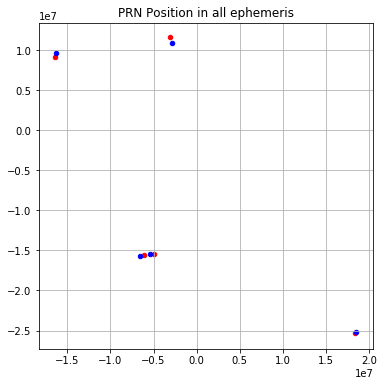

In [72]:
fig =plt.figure(figsize=(6,6))
plt.scatter(PosX,PosY,s=20,alpha=1,color='red')
plt.scatter(Orix,Oriy,s=20,alpha=1,color='blue')
plt.title('PRN Position in all ephemeris')
plt.grid()

In [ ]:
print bcestore.getInitialTime()
print bcestore.getFinalTime()
print "Input Date",InputDate
print "Time in UTC", systime
systime.setTimeSystem(gpstk.TimeSystem("GPS"))
#print gpstime.setTimeSystem(gpstk.TimeSystem('GPS'))
gpstime = copy.copy(bcestore.getFinalTime()) #copy.copy(systime)
gpstime.addSeconds(+5)
print "Time in GPS",gpstime
#print gpstk.GPSWeek(systime)

In [ ]:
#for now, look the first time


In [ ]:
for satID in range (1,2):
    print satID,type(satID)
    sat_label = "GPS " + str(satID)
    gpstime.setTimeSystem(gpstk.TimeSystem('GLO'))
    print sat_label,gpstime, type(gpstime)
    try:
        eph   = bcestore.findEphemeris(sat_label, gpstime)
        svXvt = eph.svXvt(gpstime)
        elev = obsHeader.antennaPosition.elvAngle(svXvt.getPos())
        azim  = obsHeader.antennaPosition.azAngle(svXvt.getPos())
    except ValueError:
        print "Error"


In [ ]:
%run -i utils/position_difference.py

Some [help](http://web.ics.purdue.edu/~ecalais/teaching/geodesy/EAS_591T_2003_lab_4.htm) with the Equations. and a paper with this [same](http://web.cecs.pdx.edu/~ssp/Reports/2006/Monaghan.pdf) 

In [ ]:
obsHeader, obsData = gpstk.readRinex3Obs(obsfile)
#obsObject = obsData.next()
for obsObject in obsData: #round the data
    for satID, datumList in obsObject.obs.iteritems():

        eph   = bcestore.findEphemeris(satID, obsObject.time)
        svXvt = eph.svXvt(obsObject.time)
        elev = obsHeader.antennaPosition.elvAngle(svXvt.getPos())
        azim    = obsHeader.antennaPosition.azAngle(svXvt.getPos())

        if(satID.system != satID.systemGPS):
            print satID.system, satID.id
        #print satID.system, satID.id
        AllSat.append('PRN ' + str(satID.id))
        Elevations.append(elev)
        Azimuths.append(azim)

In [ ]:
#Thx to https://github.com/scienceopen
# Read current time from my own date and time
systime = gpstk.SystemTime()
print systime
# Convert to 'CommonTime', the standard way to handle time at GPSTk
comtime = systime.toCommonTime()
print comtime
# This is the typical way to handle civil time
civtime = gpstk.CivilTime(comtime)
print civtime
# The YDSTime class is very useful for common GNSS tasks
ydstime = gpstk.YDSTime(comtime)
ydstime
# This is a typical class to handle time in GPS system
gpstime = gpstk.GPSWeekSecond(comtime)
gpstime
# Class to handle Modified Julian Date
mjd = gpstk.MJD(comtime)

#print("   The current civil time is", civtime)
print("   The current year is", ydstime.year)
print("   The current day of year is", ydstime.doy)
print("   The current second of day is", ydstime.sod)
print("   The current full GPS week is", gpstime.week)
print("   The current short GPS week is", gpstime.getModWeek())
print("   The current day of GPS week is", gpstime.getDayOfWeek())
print("   The current second of GPS week is", gpstime.sow)
#print("   The current Modified Julian Date is", mjd)

In [ ]:
OtraHora = systime.toCommonTime()
print OtraHora.setTimeSystem(gpstk.TimeSystem('GPS'))
starttime = gpstk.CommonTime()    # iterator time to start at
starttime.setTimeSystem(gpstk.TimeSystem('GPS'))
endtime = gpstk.CommonTime()  # end time, 1 day later (see below)
endtime.setTimeSystem(gpstk.TimeSystem('GPS'))
print endtime.addDays(1)

In [17]:
def GetEccentricAnomaly(ec,m,dp):
    '''
    ec = eccentricty  -  m = mean anomaly  -  dp = number of decimal
    http://www.jgiesen.de/kepler/kepler.html
    High Error.... Discart (some error with this method)
    '''
    import math
    i = 0;
    K = math.pi/180.0
    MaxIter = 100
    delta = 10**(-dp)
    #m = 360.0/m
    m = 2. *math.pi*(m - math.floor(m))
    print "Function Eccentricity Anomaly: ", K,MaxIter,delta,m
    if ec<0.8:
        E = m
    else:
        E = math.pi
    
    F = E - ec*math.sin(m) - m
    #print F
    while math.fabs(F) > delta and i < MaxIter:
        E = E - F/(1.0-ec*math.cos(E))
        F = E - ec*math.sin(E) - m
        i += 1
        print "inside While: ",E
    E=E/K
    print " BEFORE WHILE: ", K," ::: ", E, " ::: ",F
    return (E*math.pow(10,dp))/math.pow(10,dp)
    

In [32]:


#Compare Methods
import orbital
e = globalEphem
t_data = 280850
GM = 3.986004418e14     # [m^3 / s^2] value of earth universal gravitational parameter for GPS user. 
w_e = 7.2921151467e-5   # [rad/s] Value of earth rotation
toe = e.HOWtime   # Ephemeris time
M_o = e.M0  # Mean Anomaly
a = e.A # semi-major axis
ec = e.ecc #Eccentricity
delta_n = e.dn  # mean motion difference From Computed value
t = t_data - toe  # Time from ephemeris refrence epoc
uj = M_o + (math.sqrt(GM/(a**3)) + delta_n) * t          #Mean Anomaly at my time (rad/secs)
E = GetEccentricAnomaly(ec,uj,4)
print "Eccentric Anomaly: ",E
fj = TrueAnomaly(ec,E) #True Anomaly
E = MeanToEccentricAnomaly(ec,M_o)
print "Eccentric Anomaly: ",E
print "Eccentric Anomaly from Orbital: ", orbital.utilities.eccentric_anomaly_from_mean(ec,M_o)
print "Other Opction: ", OtherOpcion(ec,M_o)
#some problem whit orbital framework


Function Eccentricity Anomaly:  0.0174532925199 100 0.0001 6.20457448896
inside While:  6.20408129347
 BEFORE WHILE:  0.0174532925199  :::  355.467673872  :::  -5.97335514385e-11
Eccentric Anomaly:  355.467673872
Eccentric Anomaly:  3.26262762821
Eccentric Anomaly from Orbital:  -3.02055767897
Other Opction:  3.26262762821


In [31]:
def OtherOpcion(eccentricity,mean_anomaly,precision=50, max_iterations=1000):
    """
    Convert mean anomaly to eccentric anomaly.
    help: https://github.com/ReneHollander/solarsystem/blob/090f4fae72451e18e25d466ced67aba3937d6ba8/util/orbitalcalculations.py
    Source: https://github.com/skyfielders/python-skyfield/blob/master/skyfield/keplerianlib.py
    :param e: Eccentricity
    :param M: Mean anomaly in radians
    :param precision: Precision of the calculation
    :param max_iterations: Max iterations
    """

    tau = 2 * pi
    gravitational_constant = 6.67408 * 10 ** -11
    # calculate the delta
    delta = 10 ** -precision

    # normalize the mean anomaly
    m = mean_anomaly % tau

    # set up the first guess
    eccentric_anomaly = tau
    if eccentricity < 0.8:
        eccentric_anomaly = m

    # do the initial test
    test = eccentric_anomaly - eccentricity * sin(m) - m

    count = 0
    while (fabs(test) > delta) and (count < max_iterations):
        # calculate the next guess for an eccentric anomaly
        eccentric_anomaly = (eccentric_anomaly - test / (1.0 - eccentricity * cos(eccentric_anomaly)))

        # try it
        test = eccentric_anomaly - eccentricity * sin(eccentric_anomaly) - m

        # count the runs, so we don't go forever
        count += 1

    # convert to degrees
    return eccentric_anomaly